In [1]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import random

In [2]:
import torch
import piq
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Konfigurasi direktori dan parameter MSR
PREPROCESSED_DIR = "../ProcessedImages"
OUTPUT_DIR = "../MSRResult"
SIGMA_LIST = [15, 80, 250]  # skala kecil, menengah, besar

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
# --- Fungsi Helper ---
def plot_comparison(img_original, img_processed, title_original="Original", title_processed="Processed"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    axes[0].set_title(title_original)
    axes[0].axis("off")
    axes[1].imshow(cv2.cvtColor(img_processed, cv2.COLOR_BGR2RGB))
    axes[1].set_title(title_processed)
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

def load_image_paths(directory):
    image_paths = []
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    for root, _, files in os.walk(directory):
        for file in files:
            if os.path.splitext(file)[1].lower() in valid_extensions:
                image_paths.append(os.path.join(root, file))
    print(f"Total {len(image_paths)} gambar ditemukan.")
    return image_paths

In [5]:
# --- Fungsi Inti MSR ---

def single_scale_retinex(image, sigma):
    """
    Menerapkan Single-Scale Retinex (SSR) pada gambar.
    Bekerja di domain log: log(R) = log(S) - log(L)
    dimana L (Illumination) diestimasi dengan Gaussian blur.
    """
    # Konversi ke float64 untuk presisi logaritmik dan hindari log(0)
    img_float = image.astype(np.float64) + 1.0
    img_log = np.log(img_float)

    # Estimasi L (Illumination) dengan Gaussian Blur
    # (0, 0) berarti kernel size dihitung otomatis dari sigma
    img_blur_log = cv2.GaussianBlur(img_log, (0, 0), sigma)

    # Hitung log(R) = log(S) - log(L)
    log_r = img_log - img_blur_log
    
    return log_r

def apply_msr(image):
    """
    Menerapkan Multi-Scale Retinex (MSR) dengan menggabungkan
    beberapa hasil SSR.
    """
    # Ambil SIGMA_LIST yang sudah didefinisikan secara global di sel [3]
    
    ssr_list = []
    for sigma in SIGMA_LIST:
        ssr_list.append(single_scale_retinex(image, sigma))

    # Rata-ratakan semua hasil SSR
    msr = np.mean(ssr_list, axis=0)

    # Normalisasi hasil MSR ke rentang 0-255 untuk visualisasi
    # Ini adalah langkah "contrast stretching" sederhana
    msr_norm = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX)
    
    # Konversi kembali ke tipe data 8-bit (uint8)
    enhanced_image = msr_norm.astype(np.uint8)

    return enhanced_image

In [6]:
# --- Fungsi Evaluasi (tahan banting: coba PIQ, lalu fallback ke imquality) ---
def evaluate_quality(image):
    """
    Mengembalikan (brisque_score, niqe_score).
    Strategi: coba PIQ (beberapa lokasi API), jika gagal fallback ke imquality.* jika tersedia.
    """
    score_b = None
    score_n = None
    # Siapkan tensor untuk PIQ jika memungkinkan
    img_t = None
    try:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_t = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    except Exception as e:
        img_t = None
    # 1) BRISQUE: coba PIQ
    if img_t is not None:
        try:
            if hasattr(piq, 'brisque') and callable(piq.brisque):
                with torch.no_grad():
                    score_b = float(piq.brisque(img_t, data_range=1.0).cpu().item())
            elif hasattr(piq, 'functional') and hasattr(piq.functional, 'brisque'):
                with torch.no_grad():
                    score_b = float(piq.functional.brisque(img_t, data_range=1.0).cpu().item())
        except Exception:
            score_b = None
    # fallback BRISQUE: imquality (jika tersedia)
    if score_b is None:
        try:
            import imquality.brisque as brisque_lib
            rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            score_b = float(brisque_lib.score(rgb))
        except Exception:
            score_b = None
    # 2) NIQE: coba PIQ di beberapa lokasi; jika gagal, fallback ke imquality
    if img_t is not None:
        try:
            if hasattr(piq, 'niqe') and callable(piq.niqe):
                with torch.no_grad():
                    score_n = float(piq.niqe(img_t, data_range=1.0).cpu().item())
            elif hasattr(piq, 'functional') and hasattr(piq.functional, 'niqe'):
                with torch.no_grad():
                    score_n = float(piq.functional.niqe(img_t, data_range=1.0).cpu().item())
            else:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                gray_t = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0).float().to(device) / 255.0
                if hasattr(piq, 'niqe') and callable(piq.niqe):
                    with torch.no_grad():
                        score_n = float(piq.niqe(gray_t, data_range=1.0).cpu().item())
        except Exception:
            score_n = None
    # fallback NIQE via imquality
    if score_n is None:
        try:
            import imquality.niqe as niqe_lib
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            score_n = float(niqe_lib.score(gray))
        except Exception:
            score_n = None
    return score_b, score_n

--- Memproses 1 Contoh Gambar dengan MSR ---
Total 45 gambar ditemukan.
Menerapkan MSR pada: ../ProcessedImages\Foto Kondisi Cerah\20251021_130913.png


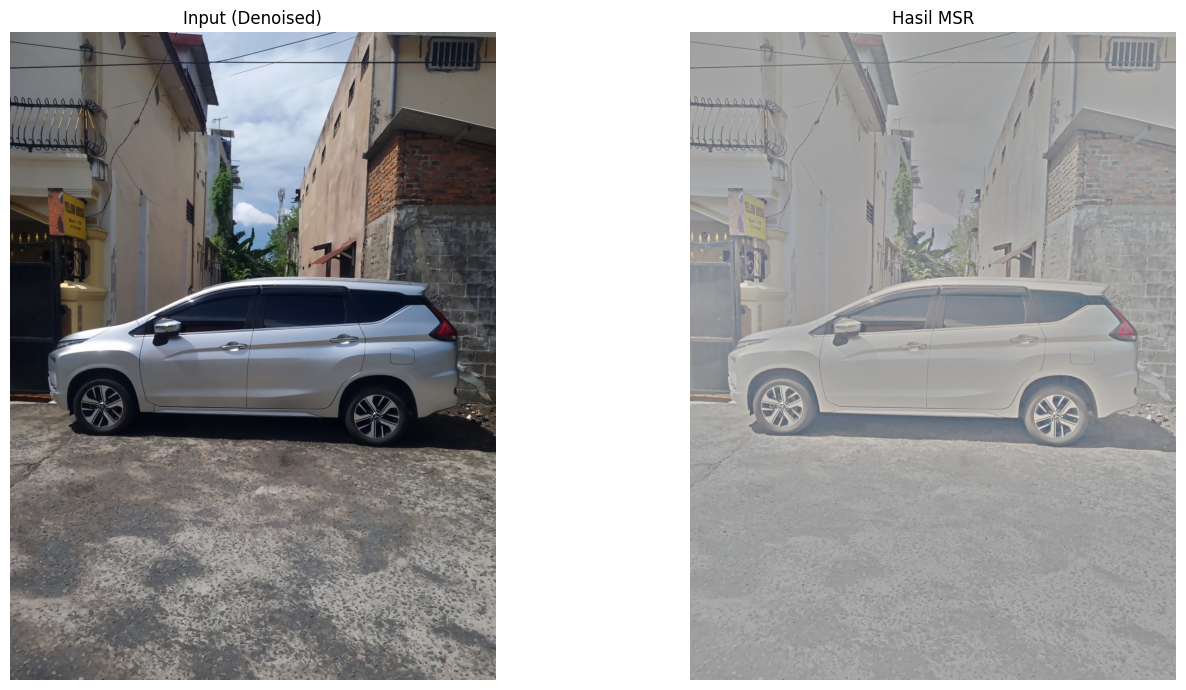

Hasil disimpan di: ../MSRResult\Foto Kondisi Cerah\20251021_130913.png

--- Evaluasi Kuantitatif (BRISQUE & NIQE) untuk 1 Contoh ---
Skor BRISQUE (Input): 45.75 (Lebih rendah lebih baik)
Skor BRISQUE (MSR):   53.88 (Lebih rendah lebih baik)
Skor NIQE (Input): N/A (Lebih rendah lebih baik)
Skor NIQE (MSR):   N/A (Lebih rendah lebih baik)


In [ ]:
# --- 1. Proses 1 Contoh Gambar ---
print("--- Memproses 1 Contoh Gambar dengan MSR ---")
preprocessed_paths = load_image_paths(PREPROCESSED_DIR)

if preprocessed_paths:
    sample_path = preprocessed_paths[random.randint(0, len(preprocessed_paths) - 1)]
    input_image = cv2.imread(sample_path)
    if input_image is not None:
        print(f"Menerapkan MSR pada: {sample_path}")
        enhanced_image = apply_msr(input_image)
        plot_comparison(input_image, enhanced_image, "Input (Denoised)", "Hasil MSR")

        # relative_path = os.path.relpath(sample_path, PREPROCESSED_DIR)
        # output_path = os.path.join(OUTPUT_DIR, relative_path)
        # os.makedirs(os.path.dirname(output_path), exist_ok=True)
        # cv2.imwrite(output_path, enhanced_image)
        # print(f"Hasil disimpan di: {output_path}")

        # Evaluasi kuantitatif untuk 1 contoh
        print("\n--- Evaluasi Kuantitatif (BRISQUE & NIQE) untuk 1 Contoh ---")
        score_input_b, score_input_n = evaluate_quality(input_image)
        score_enhanced_b, score_enhanced_n = evaluate_quality(enhanced_image)
        if score_input_b is not None and score_enhanced_b is not None:
            print(f"Skor BRISQUE (Input): {score_input_b:.2f} (Lebih rendah lebih baik)")
            print(f"Skor BRISQUE (MSR):   {score_enhanced_b:.2f} (Lebih rendah lebih baik)")
            print(f"Skor NIQE (Input): {score_input_n if score_input_n is not None else 'N/A'} (Lebih rendah lebih baik)")
            print(f"Skor NIQE (MSR):   {score_enhanced_n if score_enhanced_n is not None else 'N/A'} (Lebih rendah lebih baik)")

In [ ]:
# --- 2. Batch Processing (Proses & Evaluasi Semua Gambar) ---
print("\n--- Menjalankan Batch Processing & Evaluasi (Semua Gambar) ---")

if not preprocessed_paths:
    print("Tidak ada gambar untuk diproses. Evaluasi batch dilewati.")
else:
    # Siapkan list untuk menampung semua skor dan rows untuk CSV
    scores_input_b, scores_input_n = [], []
    scores_enhanced_b, scores_enhanced_n = [], []
    rows = []

    for path in tqdm(preprocessed_paths, desc="Menerapkan MSR ke semua gambar"):
        try:
            img = cv2.imread(path)
            if img is None:
                continue

            enhanced_img = apply_msr(img)

            relative_path = os.path.relpath(path, PREPROCESSED_DIR)
            output_path = os.path.join(OUTPUT_DIR, relative_path)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            cv2.imwrite(output_path, enhanced_img)

            # Evaluasi & Kumpulkan skor
            score_in_b, score_in_n = evaluate_quality(img)
            score_out_b, score_out_n = evaluate_quality(enhanced_img)

            if score_in_b is not None and score_out_b is not None:
                scores_input_b.append(score_in_b)
                scores_input_n.append(score_in_n)
                scores_enhanced_b.append(score_out_b)
                scores_enhanced_n.append(score_out_n)
                rows.append([relative_path, score_in_b, score_in_n, score_out_b, score_out_n])

        except Exception as e:
            print(f"Error memproses {path}: {e}")

    # --- Rangkuman Evaluasi ---
    print("\n--- Rangkuman Hasil Evaluasi Kuantitatif (BRISQUE & NIQE) ---")
    if scores_input_b:
        avg_input_b = np.mean(scores_input_b)
        avg_input_n = np.mean(scores_input_n)
        avg_enhanced_b = np.mean(scores_enhanced_b)
        avg_enhanced_n = np.mean(scores_enhanced_n)

        print(f"Total gambar dievaluasi: {len(scores_input_b)}")
        print(f"\n--- Rata-rata Skor BRISQUE --- (Lebih rendah lebih baik)")
        print(f"Input (Asli):   {avg_input_b:.2f}")
        print(f"Hasil (MSR):    {avg_enhanced_b:.2f}")

        print(f"\n--- Rata-rata Skor NIQE --- (Lebih rendah lebih baik)")
        print(f"Input (Asli):   {avg_input_n:.2f}")
        print(f"Hasil (MSR):    {avg_enhanced_n:.2f}")

        if avg_enhanced_b < avg_input_b and avg_enhanced_n < avg_input_n:
            print("\nKesimpulan: Kualitas perseptual dan statistik rata-rata MENINGKAT.")
        else:
            print("\nKesimpulan: Perlu dicek, salah satu atau kedua metrik tidak membaik.")
    else:
        print("Tidak ada gambar yang berhasil dievaluasi.")

    # --- Ekspor CSV dengan hasil per-gambar ---
    try:
        import csv
        csv_path = os.path.join(OUTPUT_DIR, 'evaluation_summary_msr.csv')
        with open(csv_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['relative_path', 'input_brisque', 'input_niqe', 'enhanced_brisque', 'enhanced_niqe'])
            writer.writerows(rows)
        print(f"CSV evaluasi disimpan di: {csv_path}")
    except Exception as e:
        print(f"Gagal menyimpan CSV: {e}")

In [ ]:
# --- Diagnostic: alasan NIQE gagal (cek PIQ/imquality) ---
print('\n--- Diagnostic NIQE availability ---')
print('piq version:', getattr(piq, '__version__', 'unknown'))
print('piq attrs:', [a for a in dir(piq) if not a.startswith('_')])
print('has piq.functional:', hasattr(piq, 'functional'))
if hasattr(piq, 'functional'):
    print('piq.functional attrs:', [a for a in dir(piq.functional) if not a.startswith('_')])
try:
    import imquality.niqe as niqe_lib
    print('imquality.niqe available')
except Exception as e:
    print('imquality.niqe not available:', e)

# Tentukan sample image (gunakan sample_path jika ada atau ambil pertama)
if 'sample_path' not in globals():
    preprocessed_paths = load_image_paths(PREPROCESSED_DIR)
    sample_path = preprocessed_paths[0] if preprocessed_paths else None
print('sample_path:', sample_path)

if sample_path is not None:
    img = cv2.imread(sample_path)
    if img is None:
        print('Gagal membaca sample image')
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        print('img shape', getattr(img, 'shape', None), 'gray shape', getattr(gray, 'shape', None))

        # siapkan tensor untuk PIQ
        try:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_t = torch.from_numpy(img_rgb).permute(2,0,1).unsqueeze(0).float().to(device)/255.0
            print('img_t:', img_t.shape, img_t.dtype, img_t.device)
        except Exception as e:
            print('img_t prep failed:', e)
            img_t = None

        try:
            gray_t = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0).float().to(device)/255.0
            print('gray_t:', gray_t.shape)
        except Exception as e:
            print('gray_t prep failed:', e)
            gray_t = None

        # Coba pemanggilan PIQ NIQE/BRISQUE
        if img_t is not None and hasattr(piq, 'brisque'):
            try:
                with torch.no_grad():
                    print('piq.brisque:', float(piq.brisque(img_t, data_range=1.0).cpu().item()))
            except Exception as e:
                print('piq.brisque failed:', e)

        # Coba NIQE top-level
        if gray_t is not None and hasattr(piq, 'niqe'):
            try:
                with torch.no_grad():
                    print('piq.niqe(gray_t):', float(piq.niqe(gray_t, data_range=1.0).cpu().item()))
            except Exception as e:
                print('piq.niqe failed:', e)

        # Coba piq.functional.niqe jika ada
        if gray_t is not None and hasattr(piq, 'functional') and hasattr(piq.functional, 'niqe'):
            try:
                with torch.no_grad():
                    print('piq.functional.niqe:', float(piq.functional.niqe(gray_t, data_range=1.0).cpu().item()))
            except Exception as e:
                print('piq.functional.niqe failed:', e)

        # Coba imquality.niqe fallback
        try:
            import imquality.niqe as niqe_lib2
            print('imquality.niqe score:', float(niqe_lib2.score(gray)))
        except Exception as e:
            print('imquality.niqe call failed:', e)


--- Diagnostic NIQE availability ---
piq version: 0.8.0
piq attrs: ['BRISQUELoss', 'CLIPIQA', 'ContentLoss', 'DISTS', 'DSSLoss', 'FID', 'FSIMLoss', 'GMSDLoss', 'GS', 'HaarPSILoss', 'IS', 'InformationWeightedSSIMLoss', 'KID', 'LPIPS', 'MDSILoss', 'MSID', 'MultiScaleGMSDLoss', 'MultiScaleSSIMLoss', 'PR', 'PieAPP', 'SRSIMLoss', 'SSIMLoss', 'StyleLoss', 'TVLoss', 'VIFLoss', 'VSILoss', 'base', 'brisque', 'clip_iqa', 'dss', 'feature_extractors', 'fid', 'fsim', 'functional', 'gmsd', 'gs', 'haarpsi', 'inception_score', 'information_weighted_ssim', 'isc', 'iw_ssim', 'kid', 'mdsi', 'ms_ssim', 'msid', 'multi_scale_gmsd', 'multi_scale_ssim', 'perceptual', 'pieapp', 'pr', 'psnr', 'srsim', 'ssim', 'total_variation', 'tv', 'utils', 'vif', 'vif_p', 'vsi']
has piq.functional: True
piq.functional attrs: ['L2Pool2d', 'average_filter2d', 'base', 'binomial_filter1d', 'colour_conversion', 'crop_patches', 'filters', 'gaussian_filter', 'get_meshgrid', 'gradient_map', 'haar_filter', 'hann_filter', 'ifftshift'